In [1]:
import torch; import torch.nn as nn; from torch.optim import lr_scheduler
import torch.optim as optim
import torch.backends.cudnn as cudnn 
from torch.utils.data.dataset import random_split as split 
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models
from torchaudio import transforms

import time
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt 
import numpy as np
import librosa 
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import os

MIN_SAMPLES = False
PATH_ANNOTATIONS = 'Wingbeats/min_annotations.txt' if MIN_SAMPLES else 'Wingbeats/annotations.txt'
n_classes = 6
lr = 1e-4
n_epochs = 50
batch_size = 32
SAMPLE_RATE = 8_000
nyquist_frequency = SAMPLE_RATE / 2
classes = ['An. gambiae', 'C. pipiens', 'C. quinquefasciatus', 'Ae. albopictus', 'An. arabiensis', 'Ae. aegypti']

n_fft = 256
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available else 'cpu'

In [2]:
def dividirDatos(archivoAnnotaciones, test_size=0.2, random_state=42):
    df = pd.read_csv(archivoAnnotaciones)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size,
        random_state=random_state,
        stratify=df['label']
    )
    print('Total = ', len(df))
    print('Total train = ', len(train_df))
    print('Total test = ', len(test_df))
    return train_df, test_df

In [3]:
class AudioDatasetFromTxt(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        audio_path = self.dataframe.iloc[index]['file_path']
        label = self.dataframe.iloc[index]['label']
        
        waveform, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
        
        waveform = torch.from_numpy(waveform).float().unsqueeze(0)
        
        if self.transform:
            spectrogram = self.transform(waveform)
            return spectrogram, label
        else:
            return waveform, label

In [4]:
spectrogram = transforms.Spectrogram(n_fft=n_fft, hop_length=n_fft//6)

In [5]:
train_df, test_df = dividirDatos(PATH_ANNOTATIONS)

Total =  279466
Total train =  223572
Total test =  55894


In [6]:
train_dataset = AudioDatasetFromTxt(train_df, transform=spectrogram)
test_dataset = AudioDatasetFromTxt(test_df, transform=spectrogram)

subgroups = ['train', 'val', 'test']

n_train = int(len(train_dataset) * 0.9)
n_val = math.ceil(len(train_dataset) * 0.1)
train_dataset, val_dataset = split(train_dataset, [n_train, n_val], 
                                   generator=torch.manual_seed(42))
datasets_Audio = [train_dataset, val_dataset, test_dataset]
audioFolder = {
    x : datasets_Audio[i]
    for i, x in enumerate(subgroups)
}
# Crear dataloaders
dataloaders = { x : torch.utils.data.DataLoader(audioFolder[x], shuffle=True, 
                                                batch_size=batch_size, num_workers=4)
               for x in subgroups}
test_loader = DataLoader(audioFolder['test'], batch_size=batch_size, shuffle=False)
dataset_size = {x : len(audioFolder[x])
                for x in subgroups}
print(dataset_size)
print(n_train, n_val)

{'train': 201214, 'val': 22358, 'test': 55894}
201214 22358


In [7]:
def plot_spect(datas, labels, hop_length=256):
    datas = [datas.squeeze() for datas in datas[:16]]
    labels = [label for label in labels[:16]]
    fig, ax = plt.subplots(4,4, figsize=(12, 8))
    for i in range(4):
        for j in range(4):
            t = np.arange(datas[i*4 + j ].shape[1]) * hop_length / SAMPLE_RATE
            ax[i, j].set_title(classes[labels[i*4 + j].item()])
            ax[i, j].imshow(librosa.power_to_db(datas[i*4 + j ]), origin="lower", aspect="auto", interpolation="none", extent=[t.min(), t.max(), 0, nyquist_frequency])
    fig.tight_layout()
    plt.show()

torch.Size([32, 1, 129, 120])
tensor([1, 0, 2, 2, 2, 5, 5, 0, 4, 5, 2, 1, 0, 0, 1, 2, 1, 2, 5, 4, 2, 4, 1, 2,
        5, 2, 5, 5, 2, 0, 0, 0])


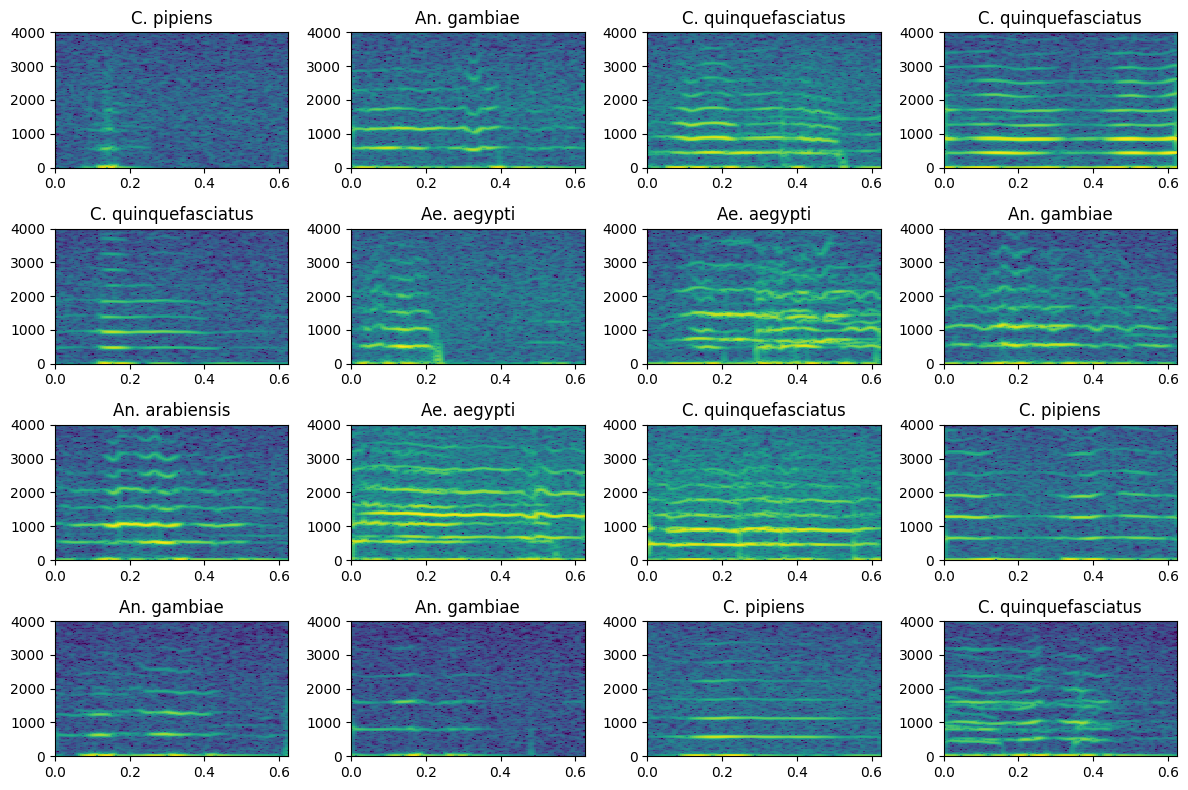

In [8]:
for data, label in dataloaders['train']:
    print(data.shape)
    print(label)
    plot_spect(data, label, hop_length=n_fft//6)
    break

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    df = pd.DataFrame(
        np.empty([num_epochs, 5]), 
        index=np.arange(num_epochs),
        columns=['loss_train', 'acc_train', 'loss_val', 'acc_val', 'lr']
    )
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        rangeEpoch = trange(num_epochs)
        for epoch in rangeEpoch:
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            # Each epoch has a training and validation phase 
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss = 0.0
                running_correct = 0
                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward 
                    # track history only if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimizer only if training phase 
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    #@ stadistics
                    running_loss =+ loss.item() * inputs.size(0)
                    running_correct += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()
                    df.iloc[epoch, 4] = optimizer.param_groups[0]['lr']
                    
                epoch_loss = running_loss / dataset_size[phase]
                epoch_acc = running_correct.double() / dataset_size[phase]
                
                if phase == 'train':
                    df.iloc[epoch, 0], df.iloc[epoch, 1] = epoch_loss, epoch_acc.item()
                else:
                    df.iloc[epoch, 2], df.iloc[epoch, 3] = epoch_loss, epoch_acc.item()
                
                rangeEpoch.set_description("train_loss=%.5f" % df.iloc[epoch, 0])
                rangeEpoch.set_postfix(
                            {'train_acc':df.iloc[epoch,1], 'test_acc':df.iloc[epoch, 3]}
                )
                
                if phase == 'val' and epoch_acc > best_acc:
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')
        print(f'Best val Acc {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

In [10]:
model_ft = models.inception_v3(weights=None, init_weights=True)
# La primera capa convolucional en InceptionV3 está en `Conv2d_1a_3x3.conv`.
original_conv = model_ft.Conv2d_1a_3x3.conv   
# Reemplazar la capa por una nueva con 1 canal, manteniendo los demás parámetros.
model_ft.Conv2d_1a_3x3.conv = nn.Conv2d(
        1,
        original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=original_conv.bias
)

num_ftrs_fc = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs_fc, 6)
num_ftrs_aux = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs_aux, 6)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
modelo = 'inception'
version = '3'
PATH_RESNET = f'./resultados/{modelo}{version}AudioBalanceado.pt' if MIN_SAMPLES else f'./resultados/{modelo}{version}AudioNoBalanceado.pt'
PATH_CSV_RESULTADOS = f'./resultados/{modelo}{version}ResultadoBalanceado.csv' if MIN_SAMPLES else f'./resultados/{modelo}{version}ResultadoNoBalanceado.csv'
if not os.path.exists(PATH_RESNET):
    model_ft, df = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)
    df.to_csv(PATH_CSV_RESULTADOS,index=False)
    torch.save(model_ft, PATH_RESNET)

NameError: name 'trange' is not defined